# Physics 5300 Final Problem Set - Gravitational Orbits in Cartesian Coordinates

#### Cassie Moats

*transfer equations here as markdown*

In [1]:
# import statements

%matplotlib inline

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
class GravitationalOrbit:
    """
    ADD INFO
    
    Parameters
    ----------
    m_1 : float
    m_2 : float
    G : float
    
    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    
    def __init__(self, m1=1., m2=1., G=1.):
        self.m1 = m1
        self.m2 = m2
        self.G = G
    
   
    def dz_dt(self, t, z):
        """
        This function returns the right-hand side of the diffeq: 
        [dz/dt d^2z/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        z : float
            3-component vector with:
                z[0] = x1(t) and z[1] = x1dot(t)
                z[2] = x1(t) and z[3] = x1dot(t)
                z[4] = x2(t) and z[5] = x1dot(t)
                z[6] = x2(t) and z[7] = x1dot(t)
                
        Returns
        -------
            
        """
        r = np.sqrt((z[0] - z[4])**2 + (z[2] - z[6])**2)
        return [z[1], self.G*self.m2*(z[4] - z[0])/r**3,
               z[3], self.G*self.m2*(z[6] - z[2])/r**3,
               z[5], -self.G*self.m1*(z[4] - z[0])/r**3,
               z[7], -self.G*self.m1*(z[6] - z[2])/r**3]
    
    def solveODE(self, t_pts, z0,
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Use solve_ivp with the option of specifying the method.
        Specify smaller abserr and relerr to get more precision.
        """
        
        solution = solve_ivp(self.dz_dt, (t_pts[0], t_pts[-1]), 
                             z0, t_eval=t_pts, method='RK23', 
                             atol=abserr, rtol=relerr)
        x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot = solution.y
        return x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot
    
    def solve_ode_Leapfrog(self, t_pts, z_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        x1_0, x1dot_0, y1_0, y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0 = z0
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        
        x1 = np.zeros(num_t_pts)
        x1dot = np.zeros(num_t_pts)
        x1dot_half = np.zeros(num_t_pts)
        
        y1 = np.zeros(num_t_pts)
        y1dot = np.zeros(num_t_pts)
        y1dot_half = np.zeros(num_t_pts)
        
        x2 = np.zeros(num_t_pts)
        x2dot = np.zeros(num_t_pts)
        x2dot_half = np.zeros(num_t_pts)
        
        y2 = np.zeros(num_t_pts)
        y2dot = np.zeros(num_t_pts)
        y2dot_half = np.zeros(num_t_pts)
        
        # initial conditions
        x1[0] = x1_0
        x1dot[0] = x1dot_0
        
        y1[0] = y1_0
        y1dot[0] = y1dot_0
        
        x2[0] = x2_0
        x2dot[0] = x2dot_0
        
        y2[0] = y2_0
        y2dot[0] = y2dot_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            
            z = [x1[i], x1dot[i], y1[i], y1dot[i], x2[i], x2dot[i], y2[i], y2dot[i]]
            out = self.dz_dt(t,z)
            
            x1dot_half[i] = x1dot[i] + out[1]*delta_t/2.
            x1[i+1] = x1[i] + x1dot_half[i]*delta_t
            
            y1dot_half[i] = y1dot[i] + out[3]*delta_t/2.
            y1[i+1] = y1[i] + y1dot_half[i]*delta_t
            
            x2dot_half[i] = x2dot[i] + out[5]*delta_t/2.
            x2[i+1] = x2[i] + x2dot_half[i]*delta_t
            
            y2dot_half[i] = y2dot[i] + out[7]*delta_t/2.
            y2[i+1] = y2[i] + y2dot_half[i]*delta_t
            
            z = [x1[i+1], x1dot[i], y1[i+1], y1dot[i], x2[i+1], x2dot, y2[i+1], y2dot[i]]
            out = self.dz_dt(t,z)
            
            x1dot[i+1] = x1dot_half[i] + out[1]*delta_t/2.
            y1dot[i+1] = y1dot_half[i] + out[3]*delta_t/2.
            x2dot[i+1] = x2dot_half[i] + out[5]*delta_t/2.
            y2dot[i+1] = y2dot_half[i] + out[7]*delta_t/2.
            
        return x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot  
    
    def solve_ode_Leapfrog_n(self, t_pts, z_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method. Generalized for n points.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        n_total = len(z0)
        z = np.zeros(shape=(n_total, num_t_pts))
        dot_half = np.zeros((int(n_total/2)))
        
        # initial conditions
        z[:,0] = z0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            
            z_now = z[:,i]
            out = np.asarray(self.dz_dt(t,z_now)) # converting to numpy array
            
            dot_half = z_now[1::2] + out[1::2]*delta/2                  
            z[0::2, i+1] = z_now[0::2] + dot_half*delta_t
            
            z_now[0::2] = z[0::2] + dot_half*delta_t
            out = np.asarray(self.dz_dt(t,z_now))
                              
            z[1::2, i+1] = dot_half + out[1::2]*delta_t/2.
            
        return z 

In [3]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line    

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [5]:
# labels for plot axes 
orbitLabels = (r'$t$', r'$y$')

# plotting time 
t_start = 0.
t_end = 10.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

In [6]:
# set values for variables for orbit 1
G = 1.
m1 = 1.
m2 = 5. 

orbit1 = GravitationalOrbit(m1=m1, m2=m2, G=G) # using above values in the GravitationalOrbit method

x1_0, x1dot_0 = 1., -1 # setting inital x1 value and initial rate of change of x1
y1_0, y1dot_0 = 1., 1. # setting inital y1 value and initial rate of change of y1
x2_0, x2dot_0 = -(m1/m2)*x1_0, -(m1/m2)*x1dot_0 # setting the initial x2 value and initial rate of change of x2
y2_0, y2dot_0 = -(m1/m2)*y1_0, -(m1/m2)*y1dot_0 # setting inital y2 value and initial rate of change of y2

# taking the above initializations to define the overall initial z position and rate of change
z0 = [x1_0, x1dot_0, y1_0, y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0] 

# from the orbit produced above, use the range of time and initalized z position and rate of change 
# with to solve the ODE for the values as time passes
# returns arrays for each value
x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot = orbit1.solveODE(t_pts, z0)

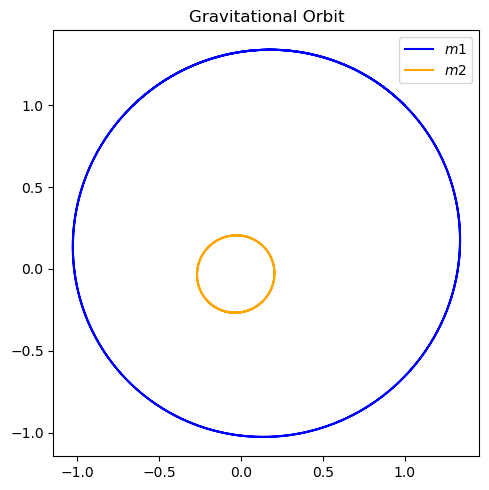

In [7]:
# starting the figure
fig = plt.figure(figsize=(5,5))

# first plotting the orbit
ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)   
ax.plot(x1, y1, color='blue', label=r'$m1$') 
ax.plot(x2, y2, color='orange', label=r'$m2$') 
ax.set_title('Gravitational Orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()

In [8]:
t_start = 0.
t_end = 20.
delta_t = 0.00001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

In [9]:
G = 20.
m1 = 20.
m2 = 1. 

orbit1 = GravitationalOrbit(m1=m1, m2=m2, G=G)

x1_0, x1dot_0 = 0.1, 0.
y1_0, y1dot_0 = 0., 0.75
x2_0, x2dot_0 = -(m1/m2)*x1_0, -(m1/m2)*x1dot_0
y2_0, y2dot_0 = -(m1/m2)*y1_0, -(m1/m2)*y1dot_0

z0 = [x1_0, x1dot_0, y1_0, y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0]
x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot = orbit1.solveODE(t_pts, z0)

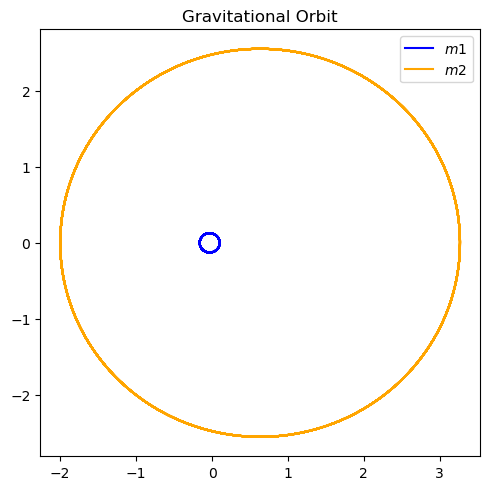

In [10]:
# starting the figure
fig = plt.figure(figsize=(5,5))

# first plotting the orbit
ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1, y1, color='blue', label=r'$m1$')  
ax.plot(x2, y2, color='orange', label=r'$m2$') 
ax.set_title('Gravitational Orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()

In [11]:
t_start = 0.
t_end = 50.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

In [12]:
G = 10.
m1 = 1.
m2 = 1. 

orbit1 = GravitationalOrbit(m1=m1, m2=m2, G=G)

x1_0, x1dot_0 = 1., 0.
y1_0, y1dot_0 = 0., 1.
x2_0, x2dot_0 = -(m1/m2)*x1_0, -(m1/m2)*x1dot_0
y2_0, y2dot_0 = -(m1/m2)*y1_0, -(m1/m2)*y1dot_0

z0 = [x1_0, x1dot_0, y1_0, y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0]
x1, x1dot, y1, y1dot, x2, x2dot, y2, y2dot = orbit1.solveODE(t_pts, z0)

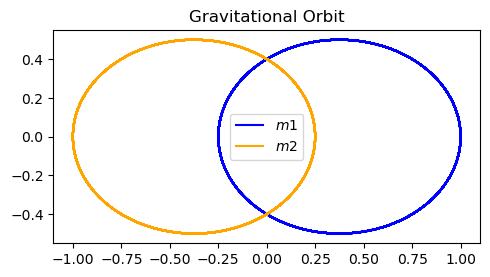

In [13]:
# starting the figure
fig = plt.figure(figsize=(5,5))

# first plotting the orbit
ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1, y1, color='blue', label=r'$m1$')  
ax.plot(x2, y2, color='orange', label=r'$m2$') 
ax.set_title('Gravitational Orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()

In [14]:
%%capture

xMin = -3.2
xMax = -xMin
yMin = -3.2
yMax = -yMin

fig_anim = plt.figure(figsize=(5,5), num='Gravitational Orbit')
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(xMin, xMax)
ax_anim.set_ylim(yMin, yMax)

ln1_anim, = ax_anim.plot(x1, y1, color='blue', lw=3)
pt1_anim, = ax_anim.plot(x1[0], y1[0], 
                         "o", markersize=12, 
                         color='blue')

ln2_anim, = ax_anim.plot(x2, y2, color='orange', lw=3)
pt2_anim, = ax_anim.plot(x2[0], y2[0], 
                        "o", markersize=12, 
                         color='orange')
ax_anim.set_aspect(1)
ax_anim.axis('off')                  
fig_anim.tight_layout()

In [15]:
def animateOrbit(i):
    """This is the function called by FuncAnimation to create each frame,
        numbered by i.  So each i corresponds to a point in the t_pts
        array, with index i.
    """
    i_skip = 1*i
    
    pt1_anim.set_data(x1[i_skip], y1[i_skip])
    pt2_anim.set_data(x2[i_skip], y2[i_skip])
    
    return (pt1_anim, pt2_anim)

In [16]:
frame_interval = 20.  # time between frames
frame_number = 10001    # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animateOrbit, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True,
                               repeat=False)

In [17]:
HTML(anim.to_jshtml())

Animation size has reached 20974281 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


IndexError: index 5001 is out of bounds for axis 0 with size 5001